In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import os

import nilearn
from nilearn import decoding, image, plotting

from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_img, show, plot_glass_brain
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from nilearn.decoding import SearchLight, Decoder

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn import naive_bayes, model_selection 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import permutation_test_score

from atlasreader import create_output
from IPython.display import display, HTML

from nilearn.input_data import NiftiMasker

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [4]:
## Load models 
f = open("../out/all_flm_IGT.pkl", 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()
## load beta maps etc
f = open("../out/tbt_all_flm_IGT.pkl", 'rb')
models_t, lsa_dm, b_maps, conditions_labels = pickle.load(f)
f.close()

In [2]:
def reshape_data(sub_ind, conditions_labels, b_maps):
    n_trials = len(conditions_labels[sub_ind])
    b_maps_conc = concat_imgs(b_maps[sub_ind])

    idx_decks = [int(i) for i in range(n_trials) if 'decks_' in conditions_labels[sub_ind][i]]
    idx_win = [int(i) for i in range(n_trials) if 'win_' in conditions_labels[sub_ind][i]]
    idx_loss = [int(i) for i in range(n_trials) if 'loss_' in conditions_labels[sub_ind][i]]

    for i in range(len(conditions_labels[sub_ind])):
        if i in idx_decks:
            conditions_labels[sub_ind][i] = 'decks'
        if i in idx_win:
            conditions_labels[sub_ind][i] = 'win'
        if i in idx_loss:
            conditions_labels[sub_ind][i] = 'loss'

    idx = np.concatenate((idx_win, idx_loss))
    condition = np.array(conditions_labels[sub_ind])[idx]
    b_maps_img = index_img(b_maps_conc, idx)

    return idx, condition, b_maps_img

In [5]:
idxs = []
conditions = []
b_maps_imgs = []

for i in range(len(models_t)):
    idx, condition, b_maps_img = reshape_data(i, conditions_labels, b_maps)
    idxs.append(idx)
    conditions.append(condition)
    b_maps_imgs.append(b_maps_img)

In [6]:
i = 4
print(models_events[i][0].loc[40:]['trial_type'].value_counts())
unique, counts = np.unique(conditions_labels[i][40:80], return_counts=True)
print(np.asarray((unique, counts)).T)

trial_type
win     28
loss    12
Name: count, dtype: int64
[['loss' '12']
 ['win' '28']]


In [7]:
idx2 = np.arange(conditions[0].shape[0])
idx_train, idx_test, conditions_train, conditions_test = train_test_split(idx2, conditions[0], test_size=0.2)
fmri_img_train = index_img(b_maps_imgs[0], idx_train)
fmri_img_test = index_img(b_maps_imgs[0], idx_test)

In [81]:
subj = models[1].subject_label
mask_wb_filename = '/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
mask_img = load_img(mask_wb_filename) 

stat_slm = load_img("../out/atlasreader/stat_img.nii.gz")

In [ ]:
from scipy.stats import norm

p001_unc = norm.isf(0.001)
plot_stat_map(stat_slm, threshold = p001_unc, display_mode="mosaic", cmap="jet")

In [154]:
process_mask = mask_img.get_fdata().astype(int)
#process_mask[...,:50] = 0 #Set slices below x in the z-dimension to zero (in voxel space)
#process_mask[90:100,...] = 0 ## xaxis 
#process_mask[ , 90:100,...] = 0
#process_mask[..., 90:100] = 0
process_mask_img = new_img_like(mask_img, process_mask)

/tmp/ipykernel_776/3489272605.py:6: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


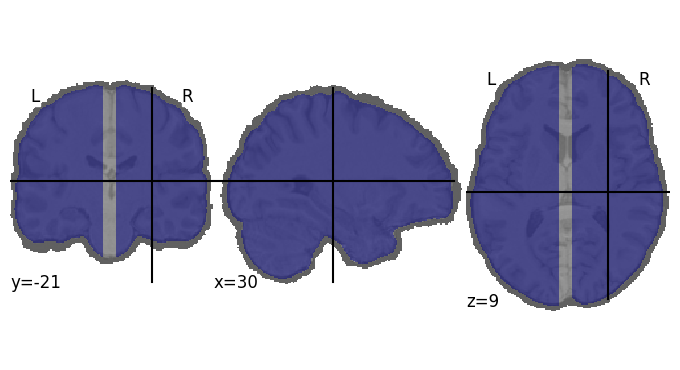

In [149]:
plotting.plot_roi(process_mask_img, bg_img = anat_filename, 
                  alpha = 0.5, black_bg = False, display_mode = 'ortho')

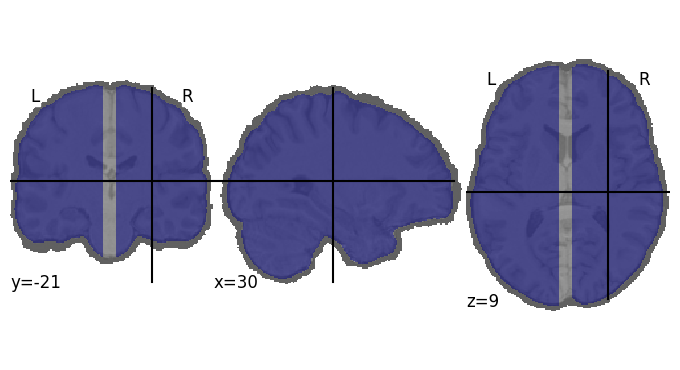

In [147]:
plotting.plot_roi(process_mask_img, bg_img = anat_filename, 
                  alpha = 0.5, black_bg = False, display_mode = 'ortho')

/tmp/ipykernel_776/3924483628.py:5: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)
/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


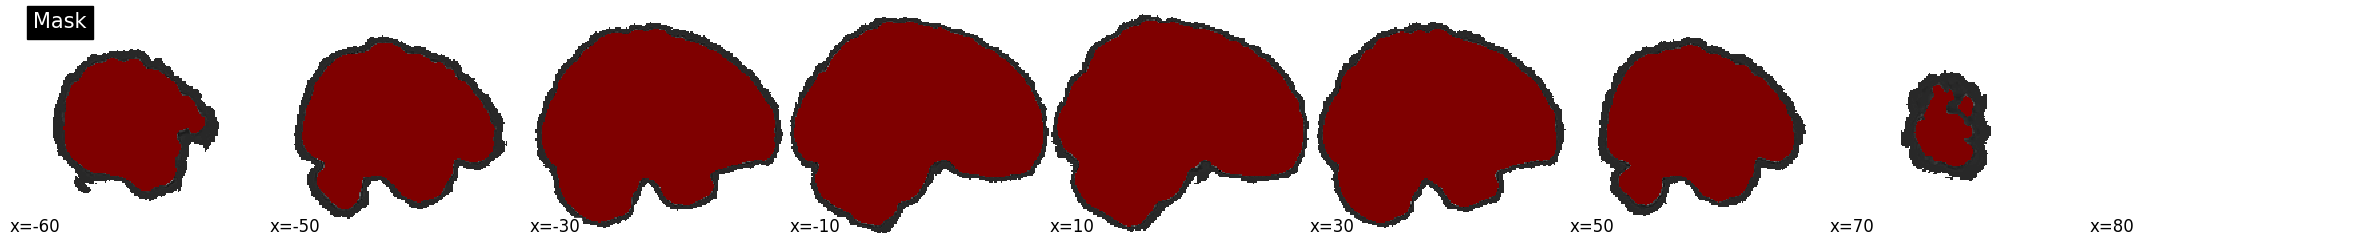

In [38]:
## process mask based on output from SLM 



In [158]:
searchlight = SearchLight(mask_img = mask_img,
                          estimator=GaussianNB(),
                          radius=5, n_jobs=-1,
                          verbose=10, cv=10)
searchlight

SearchLight(cv=10, estimator=GaussianNB(),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fdc1f456180>,
            n_jobs=-1, radius=5, verbose=10)

In [17]:
decoder = Decoder(estimator = 'logistic_l1',
                  cv = 10, t_r = 1, 
                  verbose = True, n_jobs = -1)
decoder.fit(fmri_img_train, conditions_train)

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(78, 92, 78, 128),
affine=array([[   2.52600002,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    2.52600002,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.5       ,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])
)
[NiftiMasker.fit] Computing the mask
[NiftiMasker.fit] Resampling mask
[NiftiMasker.fit] Finished fit
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(78, 92, 78, 128),
affine=array([[   2.52600002,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    2.52600002,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.5       ,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.9s finished


In [18]:
from sklearn.metrics import classification_report

y_pred = decoder.predict(fmri_img_test)
print(classification_report(conditions_test, y_pred))

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(78, 92, 78, 32),
affine=array([[   2.52600002,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    2.52600002,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.5       ,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
              precision    recall  f1-score   support

        loss       0.25      0.30      0.27        10
         win       0.65      0.59      0.62        22

    accuracy                           0.50        32
   macro avg       0.45      0.45      0.45        32
weighted avg       0.53      0.50      0.51        32



In [16]:
decoder.cv_scores_

{'loss': [0.575,
  0.525,
  0.475,
  0.725,
  0.75,
  0.625,
  0.5555555555555556,
  0.638888888888889,
  0.65625,
  0.8125],
 'win': [0.575,
  0.525,
  0.475,
  0.725,
  0.75,
  0.625,
  0.5555555555555556,
  0.638888888888889,
  0.65625,
  0.8125]}

In [ ]:
#evaluate classifier on test set 

from sklearn.metrics import classification_report
y_pred = gnb.predict(features)
print(classification_report(y, y_pred))